# Purpose

The purpose of this notebook is to document the default choices chosen for this repository, recorded below:

- `coarse_grid=7` provides a fairly low run time while maintaining the best final error
- `fine_grid=100` provides a fairly low run time while maintaining the best final error
- `finish=fmin_powell` provides the best run time and lowest errors of the finish functions tested
- `method='L-BFGS-B` provdes the best run time nad lowest errors of the final optimization methods tested

# Code

## Imports

In [1]:
import os
import platform
import timeit
import numpy as np 
from matplotlib import pyplot as plt
np.bool8 = np.bool
from plotly import express as px 
from plotly.subplots import make_subplots
import pandas
from scipy import optimize
import dghf
from scripts import canvass_download
import hill_test

## Record OS information

In [2]:
os.name, platform.uname(), platform.processor()

('posix',
 uname_result(system='Darwin', node='Patricks-MBP-3.attlocal.net', release='20.6.0', version='Darwin Kernel Version 20.6.0: Thu Jul  6 22:12:47 PDT 2023; root:xnu-7195.141.49.702.12~1/RELEASE_X86_64', machine='x86_64'),
 'i386')

## Setup functions

In [3]:
def plot_error_and_time(kw_fit_arr,x_y_kw,title,bounds,x="coarse_n",time_repeats=10,
                        convert_v=None,height=600,width=400,log_x=False):
    df_error_N, df_time_N = error_values(kw_fit_arr=kw_fit_arr,x_y_kw=x_y_kw,
                                         bounds=bounds,time_repeats=time_repeats)
    x_vals = sorted(set([e for kw in kw_fit_arr for e in kw.keys()]))
    if convert_v is not None:
        for d in [df_error_N,df_time_N]:
            for x in x_vals:
                d[x] = [convert_v[x](e) for e in d[x]]
            d.sort_values(by=x_vals,inplace=True)
    df_error_median_N = df_error_N[["Error (%)","Parameter set"] + x_vals].groupby(["Parameter set"] + x_vals).median().reset_index()
    df_time_and_error = df_error_median_N.merge(df_time_N,on=["Parameter set"] + x_vals)
    # Create subplots
    category_orders = {x:sorted(set(df_time_and_error[x]))}
    fig = make_subplots(rows=2, cols=1,horizontal_spacing=0.15)
    fig.add_trace(px.box(x=x,y="Error (%)",points="all",data_frame=df_time_and_error,
                         log_y=True,category_orders=category_orders).data[0],row=1,col=1)
    fig.add_trace(px.box(df_time_N,x=x,y="Time (s)",points="all",
                        category_orders=category_orders).data[0],row=2,col=1)
    fig.update_xaxes(title_text=x,row=1,col=1)
    fig.update_yaxes(title_text="Error (%)",type='log',row=1,col=1)
    fig.update_xaxes(title_text=x,row=2,col=1)
    fig.update_yaxes(title_text="Time (s)",row=2,col=1)
    if log_x:
        fig.update_xaxes(type='log',row=1,col=1)
        fig.update_xaxes(type='log',row=2,col=1)
    fig.update_layout(autosize=False,height=height,width=width,title=title)
    fig.show(renderer="iframe")

def error_values(kw_fit_arr,x_y_kw,bounds=None,time_repeats=0):
    errors = []
    times = []
    for kw_params in kw_fit_arr:
        for i,(x,y,kw) in enumerate(x_y_kw):
            _f_callable = lambda : dghf.fit(x,y,bounds=bounds,**kw_params)
            kw_fit = _f_callable()
            if time_repeats > 0:
                time_avg = timeit.timeit(_f_callable,number=time_repeats)
            else:
                time_avg = np.nan
            times.append({"Parameter set":i,"Time (s)":time_avg,**kw_params})
            for k,v in kw_fit.items():
                v_expected = kw[k]
                v_calculate = v 
                errors.append({"Parameter set":i,"Parameter":k,"Error (%)": 100 * abs((v_expected-v_calculate)/(v_expected)),**kw_params})
    return pandas.DataFrame(errors), pandas.DataFrame(times)

In [4]:
simulated_data = hill_test.MyTestCase().simulated_data
# ignore the all nan data set
x_y_kw = [s[0] for s in simulated_data if not set(s[0][-1].values()) == set([np.nan])]
# all of the simulated data has positive hill coefficient
bounds = [[None,None],[None,None],[None,None],[0,np.inf]]

## Optimizing fit parameters

### Determining optimum coarse grid size

In [5]:
plot_error_and_time(kw_fit_arr=[dict(coarse_n=coarse_n) for coarse_n in [1,2,3,4,5,6,7,8,9,10]],
                    x_y_kw=x_y_kw,title = "Error versus brute grid points",
                    bounds=bounds,x="coarse_n")

### Determining optimum fine grid size

In [6]:
plot_error_and_time(kw_fit_arr=[dict(fine_n=fine_n) for fine_n in [2,5,10,20,50,100,200,500,1000]],
                    x_y_kw=x_y_kw,title = "Error versus brute fine grid points",
                    bounds=bounds,x="fine_n",log_x=True)

### Determining optimum brute finish

In [7]:
plot_error_and_time(kw_fit_arr=[dict(finish=fin) for fin in [optimize.fmin,optimize.fmin_powell,
                                                             optimize.fmin_cg,optimize.fmin_bfgs]],
                    x_y_kw=x_y_kw,title = "Error versus brute finish",width=500,
                    bounds=bounds,x="finish",convert_v={"finish":lambda x: str(x).split(" at ")[0].replace("<function ","")})

### Determining optimum final polish

In [8]:
# note: 'dogleg','trust-ncg', 'trust-krylov','trust-exact' need hessian.  'COBYQA' and  'trust-constr' are very long
all_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 
               'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']
plot_error_and_time(kw_fit_arr=[dict(method=method) for method in all_methods],time_repeats=30,
                    x_y_kw=x_y_kw,title = "Error versus brute grid points",width=900,
                    bounds=bounds,x="method")

In [9]:
# Plotting CANVASS examples

In [33]:
n_sample = 25
n_side = int(np.sqrt(n_sample))
df_canvass = canvass_download.\
    read_canvass_data(out_dir="./out/test/cache_canvass",
                      random_sample=n_sample,random_seed=45)
x_y = [(df_v["Concentration (M)"].to_numpy(),df_v["Activity (%)"].to_numpy())
       for _, df_v in df_canvass.groupby("Curve ID")]
all_fit_kw = [dghf.fit(x,y) for x,y in x_y]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.72it/s]


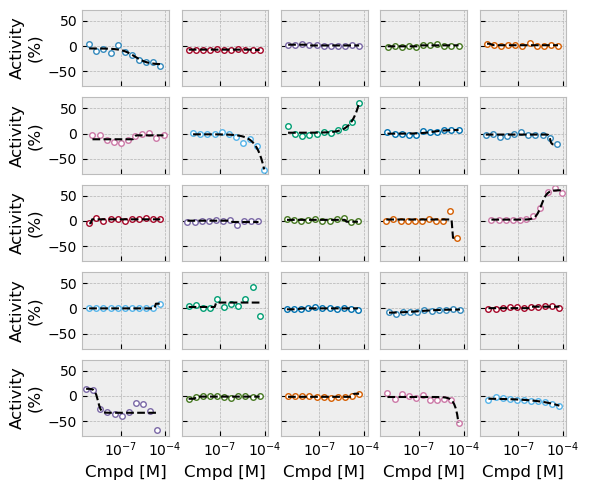

In [50]:
prop_cycle = plt.rcParams['axes.prop_cycle']
# the olive color isn't readable
colors = [c for i,c in enumerate(prop_cycle.by_key()['color'])
          if i != 8]
plt.close("all")
plt.style.use("bmh")
fig, axs = plt.subplots(n_side,n_side,figsize=(6,5),sharex=True,sharey=True,dpi=100)
i_plot = 0
for row in axs:
    for col in row:
        x,y  = x_y[i_plot]
        kw = all_fit_kw[i_plot]
        x_pred = np.logspace(np.log10(min(x)),np.log10(max(x)),
                             base=10,endpoint=True)
        y_pred = dghf.hill_log_Ka(x=x_pred, **kw)
        col.semilogx(x,y,'o',markersize=4,markerfacecolor='w',
                     color=colors[i_plot % len(colors)])
        col.semilogx(x_pred,y_pred,'--',color='k',linewidth=1.5)
        i_plot += 1
for ax in axs.flat:
    ax.set(xlabel='Cmpd [M]', ylabel='Activity\n(%)')
for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.15)
fig.savefig("./out/canvass_examples.svg")
plt.show()